#Set up the environment & define residuals function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import math
import datetime 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sp


from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Residuals function

In [2]:
def examineresiduals(model, name:str="", **kwargs):
    '''
    This function was created by DASC 522 student Brian Barnsley

    
    Plots out mutiple graphs and plots to examine the residuals of a model.

    Parameters:
    
    model : an OLS model
    
    name (str) : (optional) Will be added to plot titles and filenames
    
    **kwargs : allow for customization of the various plots. Recongized variables are:
         bars (bool) : if bars is true, vertical grid lines added to Residuals vs Fitted Values
         color : Mathplotlib color value. Plot default is orchid
     edgecolor : Mathplotlib color value. Plot default is darkorchid
        marker : Mathplotlib marker style. Plot default is dot '.'

    Returns:
    Will display and save off five plots for graphic analysis of residuals. Doesn't return data to the caller.
    1. Residuals vs Fitted Values:
        The model's residuals against the model's fitted values
        Options: 'color', 'edgecolor', 'marker', 'bar' **kwargs will affect this plot
        If the bar kwarg is passed, will add two vertical lines to plot, breaking it into equal vertical thirds.
    2. Histogram and Box plot:
        Displays the two plots as a single figure for normallity check on residuals
        Uses sns.histplot, with kde=True, so returns a fitted curve over the histogram
        Options: 'color' and 'edgecolor' **kwargs will affect this plot
    3. QQ-plot of residuals
        Options: 'marker' and 'edgecolor' **kwargs will affect this plot
    4. Standardized Residuals vs Fitted Line to check for outliers
        Options: 'color' and 'marker' **kwargs will affect this plot
    5. Influence plot showing H Leverage against the studentized residuals
        No options will change color scheme layout
    '''


    name = name.rstrip()
    name = name + "_"

    # set up some defaults and check kwargs for customization
    dft_color = 'orchid'
    dft_color2 = 'darkorchid'
    dft_marker = '.'
    gridit = False

    if 'color' in kwargs:
        color1 = kwargs.get("color")
    else:
        color1 = dft_color
    if 'edgecolor' in kwargs:
        color2 = kwargs.get('edgecolor')
    else:
        color2 = dft_color2
    if 'marker' in kwargs:
        marker = kwargs.get('marker')
    else:
        marker = dft_marker
    if 'bars' in kwargs:
        gridit = True

    # get x axis - the Fitted values
    Fitted_Values = model.fittedvalues
    
    # now Y axis - of different flavors
    #Pull Residuals
    Residuals = model.resid

    # standardized residuals
    results = model.model.fit()
    influence = results.get_influence()
    Std_Resid = influence.resid_studentized_internal

    # Studentized redisidual. Just in case.
    # Stud_Resid = influence.resid_studentized_external

    # Now the graphs

    #Plot Residuals vs Fitted Values
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(Fitted_Values, Residuals, alpha=1.0, color=color1, marker=marker)
    fig.suptitle('Residuals versus Fitted Values '+name[:-1]+' Model')
    ax.set_title(" ")
    plt.ylabel("Residual")
    plt.xlabel("Fitted Values")
    fig.tight_layout(pad=2)
    ax.grid(True)
    plt.axhline(y=0,color='black')
    if gridit:
        plt.axvline(x=min(Fitted_Values)+(max(Fitted_Values)-min(Fitted_Values))/3, color=color2)
        plt.axvline(x=min(Fitted_Values)+2*(max(Fitted_Values)-min(Fitted_Values))/3, color=color2)
    fig.savefig(name+'Residuals_fig1.png', dpi=300)

    #Check for normality distribution of residuals
    fig2, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,8))
    sns.boxplot(x=Residuals, color=color2, ax=ax_box)
    sns.histplot(Residuals, kde=True, ax=ax_hist, color=color1, edgecolor=color2)
    #fig2.suptitle(name[:-1]+" Model Residuals Normality Ceck")
    ax_box.set_title(name[:-1]+" Model Residuals Normality Check")
    ax_box.set(xlabel='Residuals')
    fig2.savefig(name+'Residuals_fig2_Histogram.png', dpi=300)

    #Check for normality distribution of residuals - QQ plot
    pp = sm.ProbPlot(Residuals, stats.norm, fit=True)
    fig3 = pp.qqplot(marker='.', markerfacecolor=color2, markeredgecolor=color2, alpha=0.8)
    fig3.suptitle(name[:-1]+" Model Residuals as QQ-Plot Normality Check")
    sm.qqline(fig3.axes[0], line='45', fmt='k--')
    fig3.savefig(name+'Residuals_fig3_QQplot.png', dpi=300)
    
    #Plot Standard Residuals vs Fitted Values
    fig4, ax = plt.subplots(figsize=(12,8))
    ax.scatter(Fitted_Values, Std_Resid, alpha=1.0, color=color1, marker=marker)
    fig4.suptitle('Standard Residuals versus Fitted Values for '+name[:-1]+' Model')
    ax.set_title(" ")
    plt.ylabel("Standard Residual")
    plt.xlabel("Fitted Values")
    fig4.tight_layout(pad=2)
    ax.grid(True)
    plt.axhline(y=0, color='black')
    plt.axhline(y= +3, color='xkcd:cool grey', linestyle = '--')
    plt.axhline(y= -3, color='xkcd:cool grey', linestyle = '--')
    fig4.savefig(name+'Residuals_fig4_Standard.png', dpi=300)

    #Influence Plot
    fig5, ax = plt.subplots(figsize=(12,8))
    fig5 = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
    ax.set_title(name[:-1]+" Model Influence Plot")
 
    fig5.savefig(name+'Residuals_fig5_Influence_Plot.png', dpi=300)

    plt.show()

    return

#Load, Understand and Split the data

In [3]:
data = pd.read_csv("FY20AuditData2.csv")

print(data.dtypes)

df = data[{"Summ", "AICdays", "CDA", "Mngt", "Workddays"}]
print(df.head())

ProjectStart     object
Summ              int64
AICdays           int64
CDA               int64
Region           object
Mngt            float64
Workddays         int64
dtype: object
   Workddays  Summ  AICdays   Mngt  CDA
0         22   132      178  33.39    0
1         23    41      134  37.32    1
2         22   174      211  32.73    0
3         23    35      184   9.74    0
4         23   110      178  20.63    0


Data Understanding

In [4]:
# data understanding
print(df.dtypes)
print(df.describe())

Workddays      int64
Summ           int64
AICdays        int64
Mngt         float64
CDA            int64
dtype: object
        Workddays        Summ     AICdays        Mngt        CDA
count  465.000000  465.000000  465.000000  465.000000  465.00000
mean    21.643011  112.232258  196.802151   25.733677    0.31828
std      1.721279   56.672017   64.059270   10.673474    0.46631
min     14.000000    8.000000   71.000000    7.890000    0.00000
25%     22.000000   75.000000  158.000000   14.560000    0.00000
50%     22.000000  103.000000  184.000000   29.850000    0.00000
75%     23.000000  135.000000  224.000000   33.390000    1.00000
max     23.000000  399.000000  556.000000   37.380000    1.00000


Splitting Data

In [5]:
y = df[{"Summ"}]
X = df.loc[:, df.columns != 'Summ']
X=sm.add_constant(X) # add constant for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#SM with y-intercept

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.439    
Dependent Variable: Summ             AIC:                3321.0121
Date:               2021-02-18 20:24 BIC:                3339.9312
No. Observations:   325              Log-Likelihood:     -1655.5  
Df Model:           4                F-statistic:        64.31    
Df Residuals:       320              Prob (F-statistic): 7.36e-40 
R-squared:          0.446            Scale:              1580.3   
-------------------------------------------------------------------
              Coef.    Std.Err.     t     P>|t|    [0.025    0.975]
-------------------------------------------------------------------
const         -3.6066   30.1154  -0.1198  0.9047  -62.8559  55.6427
Workddays      0.7758    1.3383   0.5797  0.5625   -1.8571   3.4087
AICdays        0.5524    0.0361  15.3126  0.0000    0.4814   0.6234
Mngt          -0.3273    0.2136  -1.5326  0.1264   -0.7474   0.0929
CDA   

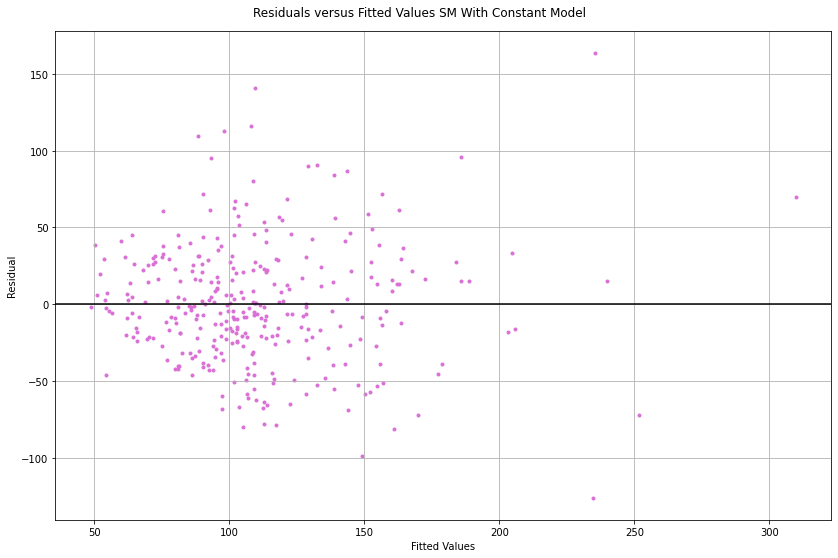

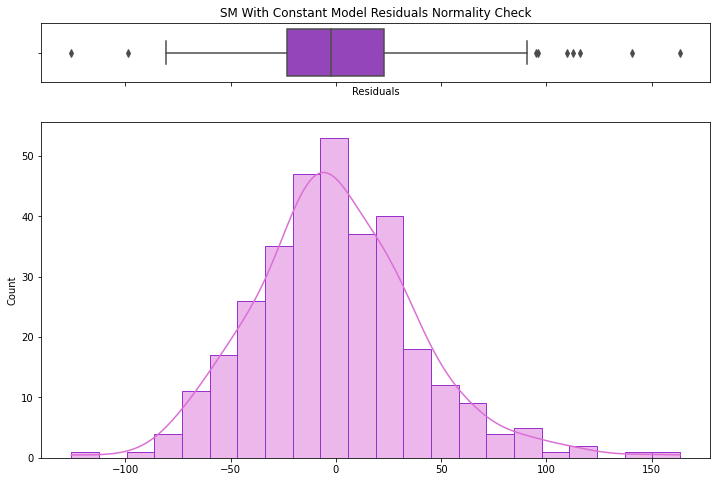

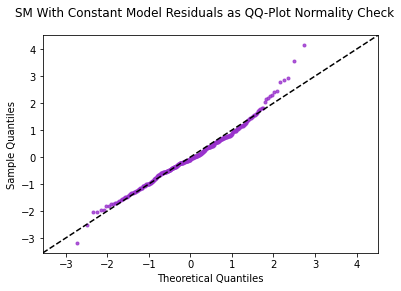

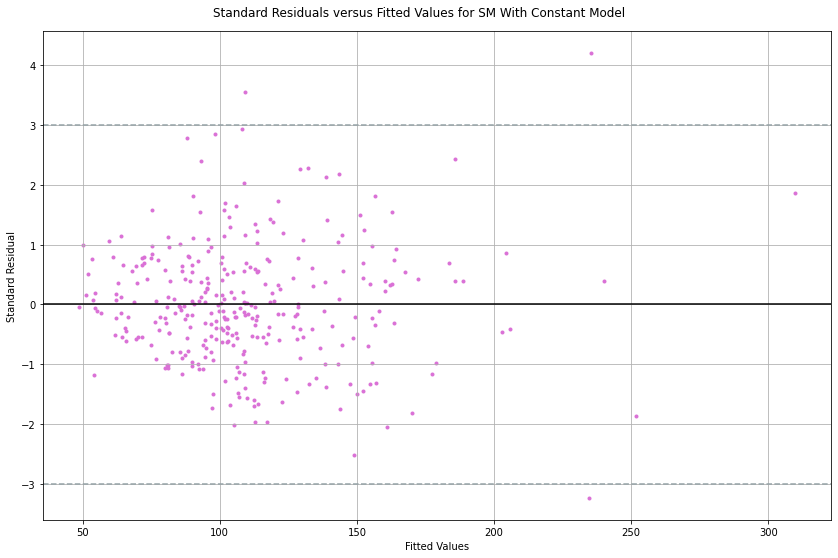

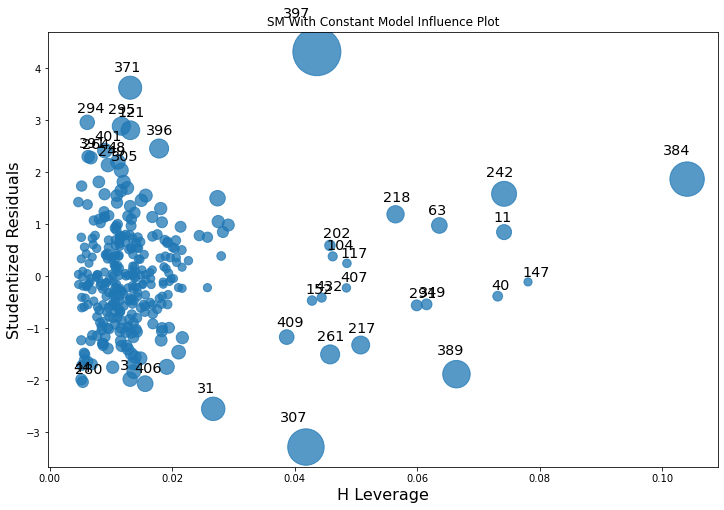

In [6]:
model_SM_with_Y = sm.OLS(y_train, X_train).fit()  # constant is included

name="SM With Constant"
OLSmodel = model_SM_with_Y

print(OLSmodel.summary2())
examineresiduals(OLSmodel, name=name)


#SM without the Y-Intercept

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.894    
Dependent Variable:     Summ             AIC:                         3319.0266
Date:                   2021-02-18 20:24 BIC:                         3334.1619
No. Observations:       325              Log-Likelihood:              -1655.5  
Df Model:               4                F-statistic:                 686.5    
Df Residuals:           321              Prob (F-statistic):          6.90e-156
R-squared (uncentered): 0.895            Scale:                       1575.4   
-----------------------------------------------------------------------------------
               Coef.       Std.Err.        t        P>|t|       [0.025       0.975]
-----------------------------------------------------------------------------------
Mngt           -0.3292       0.2126     -1.5482     0.1226      -0.7475      0.0891
CDA           -11.3435       4.7650     -2.3806 

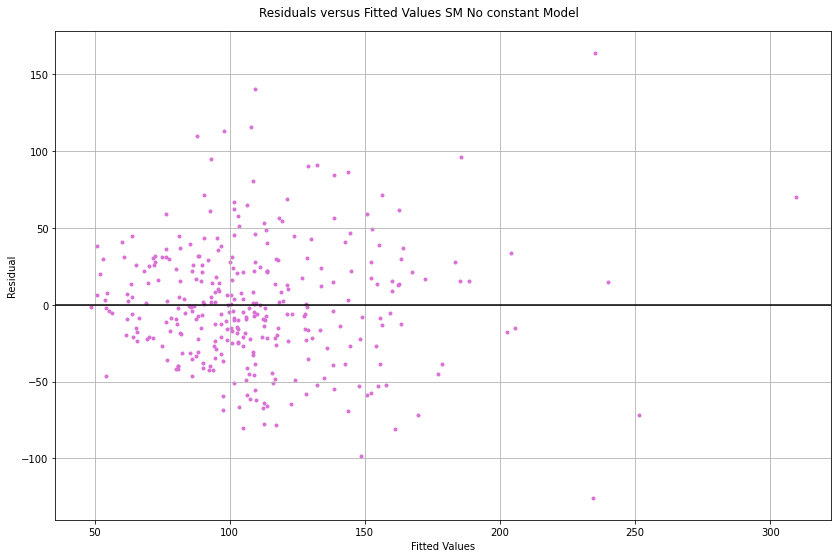

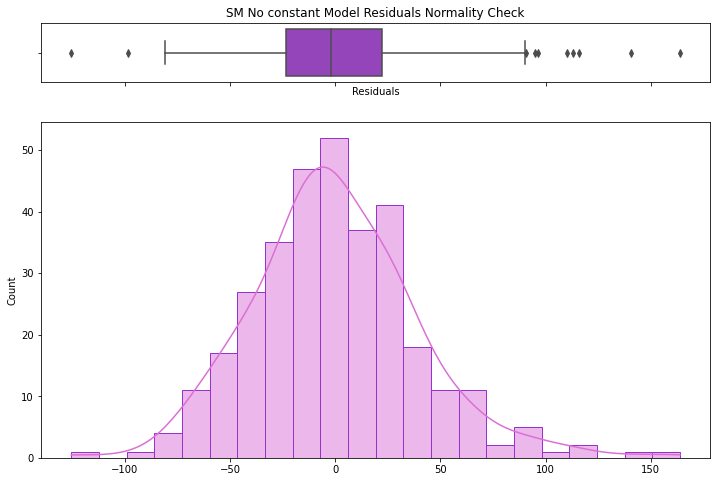

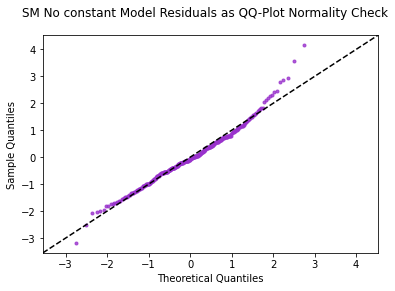

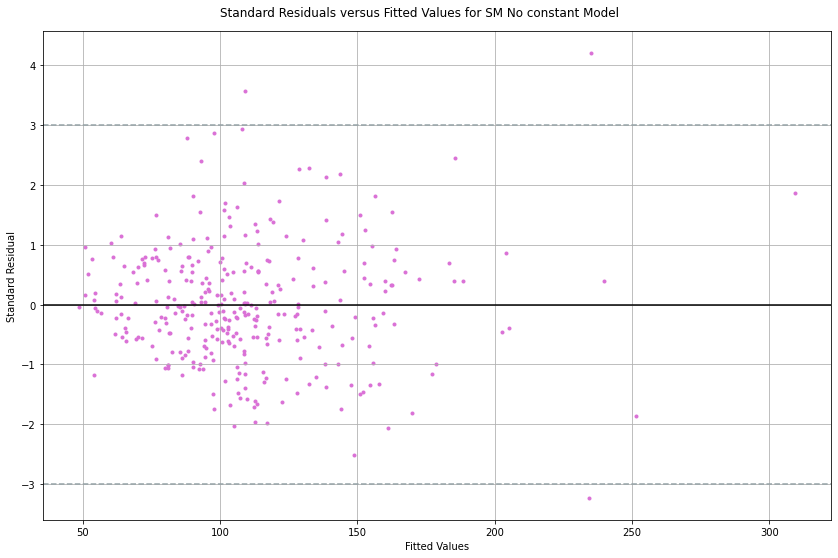

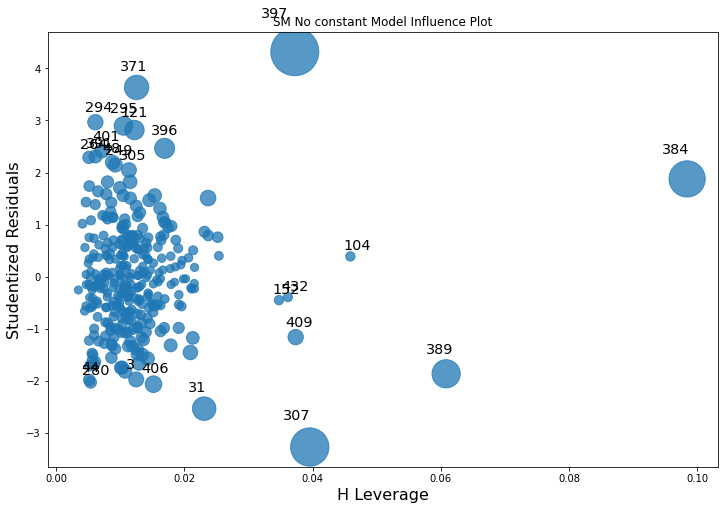

In [7]:
# Removing the constant
X_train1 = X_train[{"AICdays", "CDA", "Mngt", "Workddays"} ]

model_SM_no_Y = sm.OLS(y_train, X_train1).fit()

name="SM No constant"
OLSmodel = model_SM_no_Y

print(OLSmodel.summary2())
examineresiduals(OLSmodel, name=name)


#SMF with Y-intercept

In [ ]:
# df = data[{"Summ", "AICdays", "CDA", "Mngt", "Workddays"}]

model_SMF_with_Y = smf.ols(formula='Summ ~ AICdays + CDA + Mngt + Workddays', data=df).fit()

name="SMF with constant"
OLSmodel = model_SMF_with_Y

print(model_SMF_with_Y.summary())
examineresiduals(OLSmodel, name=name)


                            OLS Regression Results                            
Dep. Variable:                   Summ   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     99.30
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           7.19e-61
Time:                        20:24:17   Log-Likelihood:                -2391.9
No. Observations:                 465   AIC:                             4794.
Df Residuals:                     460   BIC:                             4815.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.2705     25.587      0.636      0.5

#SMF without the Y-intercept

                                 OLS Regression Results                                
Dep. Variable:                   Summ   R-squared (uncentered):                   0.891
Model:                            OLS   Adj. R-squared (uncentered):              0.890
Method:                 Least Squares   F-statistic:                              942.7
Date:                Thu, 18 Feb 2021   Prob (F-statistic):                   2.42e-220
Time:                        20:24:38   Log-Likelihood:                         -2392.1
No. Observations:                 465   AIC:                                      4792.
Df Residuals:                     461   BIC:                                      4809.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

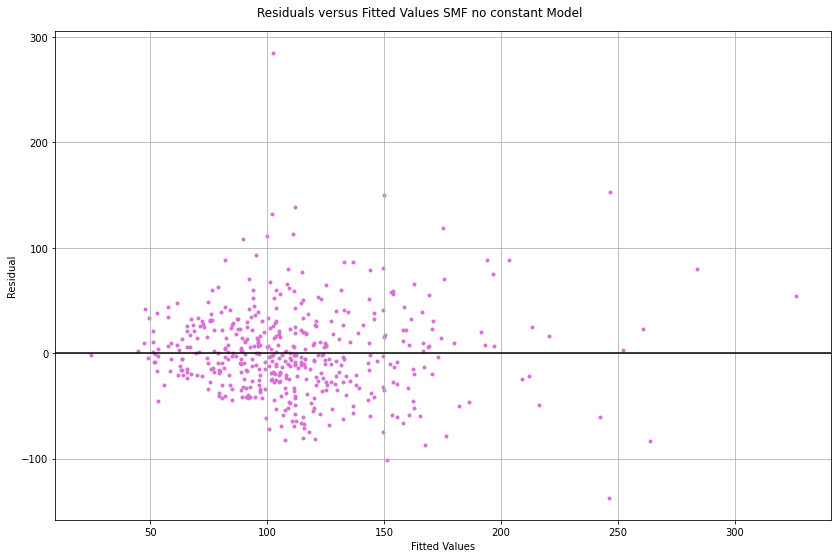

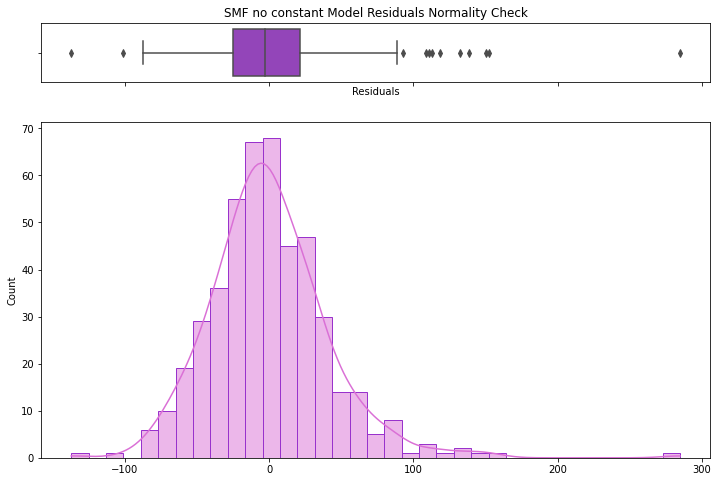

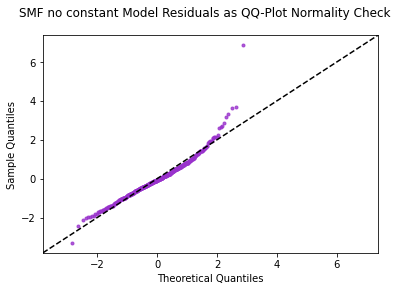

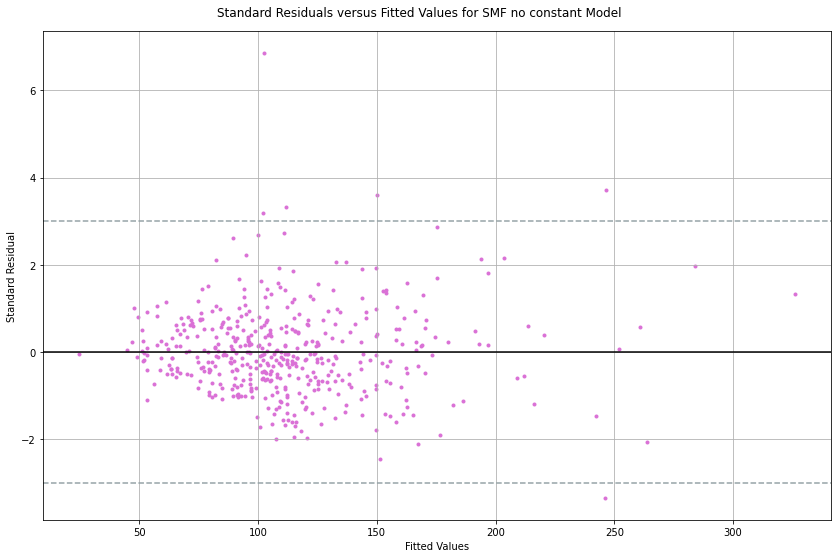

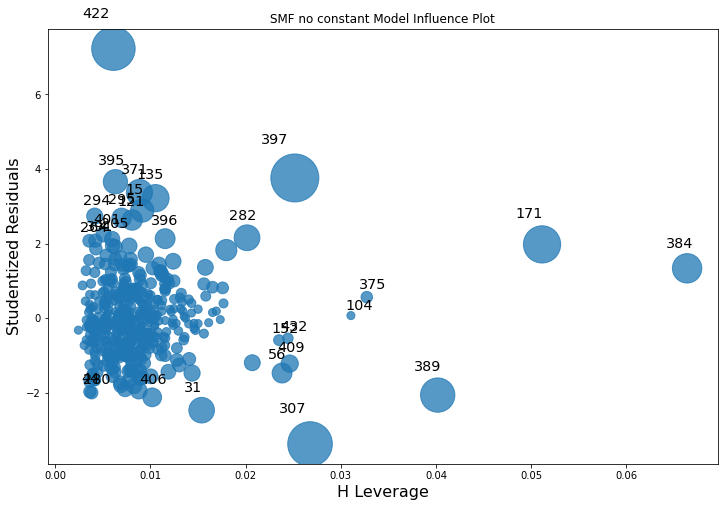

In [8]:
# df = data[{"Summ", "AICdays", "CDA", "Mngt", "Workddays"}]

model_SMF_no_Y = smf.ols(formula='Summ ~ AICdays + CDA + Mngt + Workddays -1', data=df).fit()

name="SMF no constant"
OLSmodel = model_SMF_no_Y

print(OLSmodel.summary())
examineresiduals(OLSmodel, name=name)
